<a href="https://colab.research.google.com/github/developer-ocansey/financial-fraud-detection/blob/main/fraud_detector_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
 
# mount google drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports

## Program dependencies

In [53]:
import os
import scipy
import sys
import zipfile

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as mp

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Import files from storage

In [54]:
zipRef = zipfile.ZipFile("/content/drive/My Drive/final-project/PS_20174392719_1491204439457_log.csv.zip", 'r')
zipRef.extractall("/tmp/")
zipRef.close()

# Data pre-processing

## Read data

In [55]:
# read data with pandas

data = pd.read_csv("/tmp/PS_20174392719_1491204439457_log.csv", low_memory=False)

# preview data

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Optimize data

In [56]:
# fn to optimize file memory usage

def optimizeMemUsage(dir):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = dir.memory_usage().sum() / 1024**2 
    for col in dir.columns:
        vt = dir[col].dtypes
        if vt in numv:
            max_c = dir[col].max()
            min_c = dir[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    dir[col] = dir[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    dir[col] = dir[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    dir[col] = dir[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    dir[col] = dir[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    dir[col] = dir[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    dir[col] = dir[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    dir[col] = dir[col].astype(np.float64)
    end_mem = dir.memory_usage().sum() / 1024**2
    print('Memory. usage decreased to {:5.2f} Mb ({:.1f}% reduced)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return dir

In [57]:
# data = optimizeMemUsage(data)

Memory. usage decreased to 291.26 Mb (45.5% reduced)


## Preview data

In [58]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [59]:
# check file information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int16  
 1   type            object 
 2   amount          float32
 3   nameOrig        object 
 4   oldbalanceOrg   float32
 5   newbalanceOrig  float32
 6   nameDest        object 
 7   oldbalanceDest  float32
 8   newbalanceDest  float32
 9   isFraud         int8   
 10  isFlaggedFraud  int8   
dtypes: float32(5), int16(1), int8(2), object(3)
memory usage: 291.3+ MB


In [60]:
# analyse data

data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Text(0.5, 1.0, 'Transaction types')

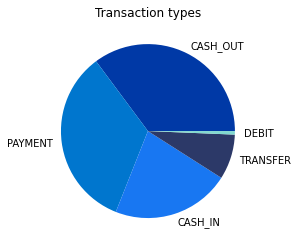

In [61]:
# preview data with metasploit

colors = ['#0039a6','#0076CE','#1877F2','#2c3968','#81D8D0']
mp.pie(data['type'].value_counts().values,labels = data['type'].value_counts().index,
        colors = colors)
mp.title('Transaction types')

In [62]:
# data correlation
corr = data.corr()

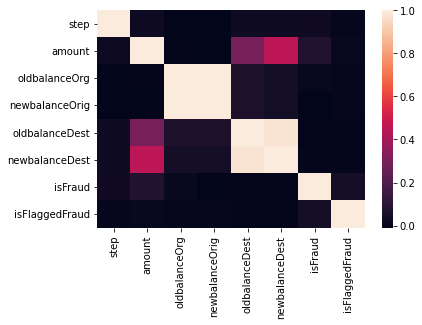

In [63]:
sb.heatmap(data.corr())

In [64]:
corr['isFraud'].reset_index().sort_values('isFraud',ascending = False)

,index,isFraud
6,isFraud,1.000000
1,amount,0.076688
7,isFlaggedFraud,0.044109
0,step,0.031578
2,oldbalanceOrg,0.010154
5,newbalanceDest,0.000535
4,oldbalanceDest,-0.005885
3,newbalanceOrig,-0.008148


In [65]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [66]:
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [67]:
data['type'] = data['type'].map({'CASH_OUT':1,'PAYMENT':2,'CASH_IN':3,'TRANSFER':4,'DEBIT':5})

In [68]:
xAxis = data[['type','amount','oldbalanceOrg','newbalanceOrig']]
xAxis

,type,amount,oldbalanceOrg,newbalanceOrig
0,2,9.839640e+03,170136.000,160296.359375
1,2,1.864280e+03,21249.000,19384.720703
2,4,1.810000e+02,181.000,0.000000
3,1,1.810000e+02,181.000,0.000000
4,2,1.166814e+04,41554.000,29885.859375
...,...,...,...,...
6362615,1,3.396821e+05,339682.125,0.000000
6362616,4,6.311410e+06,6311409.500,0.000000
6362617,1,6.311410e+06,6311409.500,0.000000
6362618,4,8.500025e+05,850002.500,0.000000


In [69]:
yAxis = data['isFraud']
yAxis

0          0
1          0
2          1
3          1
4          0
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 6362620, dtype: int8

## Train Data

In [70]:
xAxisTrain, xAxisTest, yAxisTrain, yAxisTest = train_test_split(xAxis,yAxis,test_size=0.20)

In [71]:
xAxisTrain.shape

(5090096, 4)

In [72]:
xAxisTest.shape

(1272524, 4)

## DecisionTreeClassifier Model

In [73]:
tree = DecisionTreeClassifier()
treeModel = tree.fit(xAxisTrain, yAxisTrain)

treeModel.score(xAxisTest,yAxisTest)


0.9996785915236176

In [76]:
xAxisTest.head(1)

,type,amount,oldbalanceOrg,newbalanceOrig
3792658,2,1564.609985,157053.0,155488.390625


In [75]:
yAxisTest.head(1)

3792658    0
Name: isFraud, dtype: int8

In [77]:
treeModel.predict([[3,251111.82,2679291.55,2930403.37]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([0], dtype=int8)

## Logistic Regression Model

In [ ]:
lr = LogisticRegression(solver="liblinear", random_state=42)
lr.fit(xAxisTrain, yAxisTrain[:np.shape(xAxisTrain)[0]])

In [ ]:
score = train_test_split(lr, xAxisTrain, yAxisTrain[:np.shape(xAxisTrain)[0]], cv=3, verbose=3)
score.mean()

## RandomForestClassifier Model

In [ ]:
rf = RandomForestClassifier(n_estimators=1000, bootstrap=False, max_features=0.33, n_jobs=4)
rf.fit(xAxisTrain, yAxisTrain[:np.shape(xAxisTrain)[0]])

In [ ]:
score = train_test_split(rf, xAxisTrain, yAxisTrain[:np.shape(xAxisTrain)[0]], cv=3, verbose=3)
score.mean()

# Summary

When we found that our false negatives are more important than the false positives, we have to look at the recall number and we have 99% recall in finding the fraudulent transactions and 99% precision in finding the non-fraudulent transactions and on average the accuracy of our model is over 70%, which is pretty good and there are ways to improve the performance of this model.